# Numpy operations test

Results from basic numpy operations benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in kilobytes (KiB).

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Defined tests

Currently, there are 9 different variants of benchmarks
- Matrix Multiplication
- Singular Value Decomposition (SVD)
- Cholesky Decomposition
- Eigen Decomposition
- Matrix Inversion
- 2-Dimensional Real FFT
- 2-Dimensional Real Inverse FFT
- 2-Dimensional Complex FFT
- 2-Dimensional Complex Inverse FFT

Each variant run with different number of threads, which is the test parameterisation. Please refer to `reframe_numpy.py` for benchmark runtime configurations. 

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

### Small test case results
These results correspond to small image size of the benchmark. 

The table shows results for different systems/partition/environments, variant of benchmark, different number of cores and **small** sized benchmark

In [4]:
df = modules.utils.tabulate_last_perf(test='NumpyTest*',
                                     root=PERFLOG_DIR,
                                     extras=['num_threads'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case', 'num_threads'])
display(df)

perf_var                                                   cholesky time  \
case                                          num_threads                  
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                    0.16   
generic:default:numpy                         12                    0.12   
generic:python:numpy                          12                    0.11   
grenoble-g5k:dahu-gcc9-ompi4-opa-umod:numpy   64                    0.19   

perf_var                                                   dot time  \
case                                          num_threads             
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24               0.54   
generic:default:numpy                         12               0.62   
generic:python:numpy                          12               0.69   
grenoble-g5k:dahu-gcc9-ompi4-opa-umod:numpy   64               0.18   

perf_var                                                   eigendec time  \
case                                          num_threads                  
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24                    8.02   
generic:default:numpy                         12                    6.42   
generic:python:numpy                          12                    7.04   
grenoble-g5k:dahu-gcc9-ompi4-opa-umod:numpy   64                    9.07   

perf_var                                                   inv time  svd time  
case                                          num_threads                      
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:numpy 24               0.25      0.90  
generic:default:numpy                         12               0.30      0.55  
generic:python:numpy                          12               0.30      0.49  
grenoble-g5k:dahu-gcc9-ompi4-opa-umod:numpy   64               0.30      0.77

## Performance History

The plot shows the Degrid rate, write and read bandwidths for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

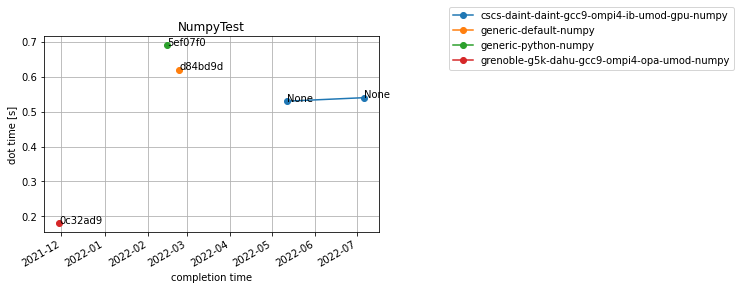

In [5]:
test='NumpyTest'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['num_threads'], test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
fig, ax = plt.subplots(nrows=1, ncols=1)
for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
    # filter to only Gflops records (might have others)
    data = data.loc[data['perf_var'] == 'dot time']
    data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

    # annotate points with git_ref:
    for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
        if not pd.isnull(ref):
            ax.annotate(ref[:7], (x, y))
ax.set_title(test)
ax.set_xlabel('completion time')
ax.set_ylabel('dot time [s]')
handles, labels = ax.get_legend_handles_labels()
ax.grid()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')